# Non-Linear Dynamic Model of a Storage Pond

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

## Model equations

Volume of water in a conical storage pond:

\begin{align}
V & = \pi R^2 \frac{h_2}{3} \\
  & = \pi (h_2 \tan{a})^2 \frac{h_2}{3} \\
  & = \pi (\tan{a})^2 \frac{h_2^3}{3} \\
\end{align}

where

\begin{align}
    V & : \text{volume } (m^3) \\
    R & : \text{radius at water level } (m) \\
    a & : \text{inclination of pond walls from vertical } (deg) \\
    h_2 & : \text{depth at deepest point } (m)
\end{align}



Francis Formula for rectangular weir flow rate:

$$q_2 = 3.33 (b - 0.2 h_1) h_1^{3/2}$$

where

\begin{align}
    q_2 & : \text{flow rate } (m^3/s) \\
    h_1 & : \text{head on the weir } (m) \\
    b & : \text{width of the weir } (m)
\end{align}

Notes:
1. This is an empirical model based on measurements
2. Provides a reasonable approximation in the range $0 < h_1 < b/3$
3. $q_2=0$ for all $h_1 < 0$.

Combined storage pond flow model:

\begin{align}
q_1 - q_2 & = \frac{\partial V}{\partial t} \\
          & = \frac{\partial}{\partial t} \left( \pi (\tan{a})^2 \frac{h_2^3}{3} \right) \\ 
q_1 - 3.33 (b - 0.2 h_1) h_1^{3/2} & = \pi (\tan{a})^2 h_2^2 \dot{h_2}
\end{align}

where

\begin{align}
q_1 & : \text{water addition rate } (m^3/s)
\end{align}


Define state of system:
\begin{align}
x & = h_1 = h_2 - d \\
\end{align}

where
\begin{align}
d & : \text{height of weir from deepest point } (m)
\end{align}

The ODE of the system is:

\begin{align}
3.33 (b - 0.2 h_1) h_1^{3/2} + \pi (\tan{a})^2 (h_1 + d)^2 \dot{h_1} - q_1 = 0
\end{align}

Define system input:
\begin{align}
u = q_1 & : \text{water addition flow rate } (m^3/s)
\end{align}

Define system output:
\begin{align}
y = h_1 & : \text{head on the weir } (m) \\
\end{align}

\begin{align}
3.33 (b - 0.2 y) y^{3/2} + \pi (\tan{a})^2 (y + d)^2 \dot{y} - u = 0 \\
\dot{y} = \left( \frac{u - 3.33 (b - 0.2 y) y^{3/2}}{\pi (\tan{a})^2 (y + d)^2} \right)
\end{align}

In state-space form:

\begin{align}
\dot{x}_t & = f(x_t, u_t) + w_t\\
y_t & = g(x_t) + v_t
\end{align}

where

\begin{align}
f(x_t, u_t) & = \left( \frac{u - 3.33 (b - 0.2 x_t) x_t^{3/2}}{\pi (\tan{a})^2 (x_t + d)^2} \right) \\
g(x_t) & = x_t
\end{align}





In [2]:
d = 5   # height of weir from deepest point (m)
a = 80  # inclination of pond walls from vertical (deg)
b = 2   # width of the weir (m)

In [3]:
# Calculate lowest radius of pond surface (at height of weir)
R0 = d * np.tan(np.deg2rad(a))
round(R0, 3)

28.356

In [4]:
c = np.pi * np.tan(np.deg2rad(a))  # constant

def f(x, u):
    assert np.all(x < 0.33 * b), "Out of bounds"
    return (u - 3.33 * (b - 0.2 * x) * x ** 1.5 ) / (c * (x + d) **2)

def g(x):
    return x

assert(f(0, 0) == 0)
try:
    f(0.34 * b, 0)
except AssertionError:
    pass
else:
    raise AssertionError("Bounds error was not raised")

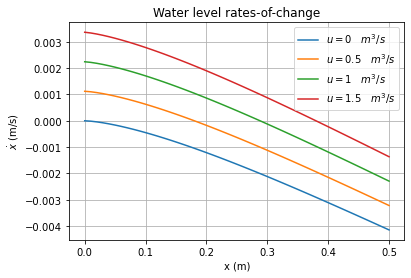

In [5]:
x_values = np.linspace(0, 0.5, 51)
u_values = [0, 0.5, 1, 1.5]
for u in u_values:
    plt.plot(x_values, f(x_values, u), label=f"$u={u} \quad m^3/s$")
plt.xlabel('x (m)')
plt.ylabel('$\dot{x}$ (m/s)')
plt.grid()
plt.legend()
plt.title("Water level rates-of-change")
plt.show()

In [6]:
# Find a stable initial condition
u0 = 1    # water addition flow rate (m^3/s)

cost_fun = lambda x : 1e6 * f(x, u0) ** 2
res = minimize(cost_fun, 0.3, bounds=[(0, 1)])
assert(res.status == 0)
assert(res.fun < 1e-8)
x0 = res.x[0]
y0 = g(x0)
round(x0, 3)

0.288

In [7]:
# Calculate radius of pond surface at initial condition (m)
R = (d + x0) * np.tan(np.deg2rad(a))
round(R, 3)

29.99

## Simulate

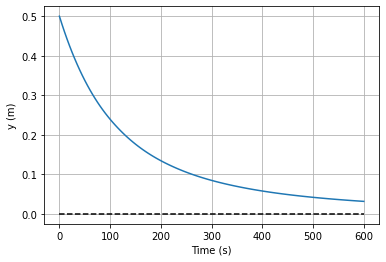

In [8]:
# Response to initial condition (with u = 0)
x = 0.5
u = 0
t_span = [0, 10*60]  # seconds
dt = 5  # seconds
N = np.diff(t_span) / dt + 1

fun = lambda t, x: f(x, u)
t_eval = dt * np.arange(N)
res = solve_ivp(fun, t_span, y0=[x], t_eval=t_eval)
assert(res.status == 0)

plt.plot(res.t, res.y[0])
plt.xlabel('Time (s)')
plt.ylabel('y (m)')
plt.hlines(0, *t_span, linestyle='--', color='k')
plt.grid()

In [9]:
# Estimate time constant
t_settle_f = interp1d(res.y[0], t_eval)
y_63pct = res.y[0][0] * (1 - 0.63)
tau = t_settle_f(y_63pct).item()
round(tau, 1)

141.9

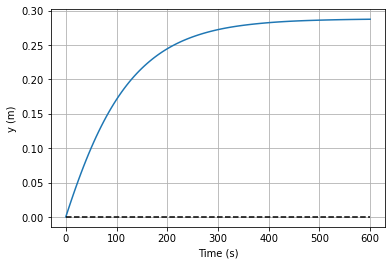

In [10]:
# Response to step in inflow (x0 = 0)
x = 0
u = 1
t_span = [0, 10*60]  # seconds
dt = 5  # seconds
N = np.diff(t_span) / dt + 1

fun = lambda t, x: f(x, u)
t_eval = dt * np.arange(N)
res = solve_ivp(fun, t_span, y0=[x], t_eval=t_eval)
assert(res.status == 0)

plt.plot(res.t, res.y[0])
plt.xlabel('Time (s)')
plt.ylabel('y (m)')
plt.hlines(0, *t_span, linestyle='--', color='k')
plt.grid()

In [11]:
# Estimate time constant
t_settle_f = interp1d(res.y[0], t_eval)
y_63pct = res.y[0][-1] * 0.63
tau = t_settle_f(y_63pct).item()
round(tau, 1)

109.5

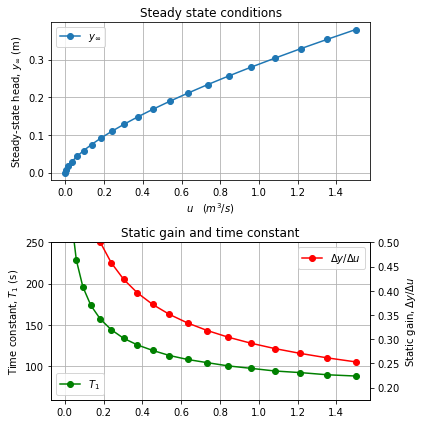

In [12]:
# Calculate steady-state conditions
# Response to step in inflow (x0 = 0)
x = 0
u_values = np.linspace(0, np.sqrt(1.5), 21) ** 2

t_span = [0, 100*60]  # seconds
dt = 5  # seconds
N = np.diff(t_span) / dt + 1
t_eval = dt * np.arange(N)

y_steady_state = []
time_constants = []

for u in u_values:

    # Simulate system
    fun = lambda t, x: f(x, u)
    res = solve_ivp(fun, t_span, y0=[x], t_eval=t_eval)
    assert(res.status == 0)

    # Steady-state output value
    y_steady_state.append(res.y[0][-1])

    # Estimate time constant
    dy = res.y[0][-1] - res.y[0][0]
    if dy > 0:
        t_settle_f = interp1d(res.y[0] - res.y[0][0], t_eval)
        dy_63pct = dy * 0.63
        tau = t_settle_f(dy_63pct).item()
    else:
        tau = np.nan
    time_constants.append(tau)

    # Use current state in next simulation
    x = res.y[0][-1]

y_steady_state = np.array(y_steady_state)
time_constants = np.array(time_constants)

old_settings = np.seterr(all='ignore')  #seterr to known value
np.seterr(over='raise')
static_gains = y_steady_state / u_values
np.seterr(**old_settings)  # reset to default

labels = ["$y_{\infty}$", "$\Delta{y}/\Delta{u}$", "$T_1$"]

fig, axes = plt.subplots(2, 1, figsize=(6, 6))

ax1 = axes[0]
ax1.plot(u_values, y_steady_state, 'o-', label=labels[0])
ax1.set_xlabel('$u \quad (m^3/s)$')
ax1.set_ylabel(f"Steady-state head, {labels[0]} (m)")
ax1.legend()
ax1.grid()
ax1.set_title('Steady state conditions')

ax2 = axes[1]
ax2.plot(u_values, time_constants, 'go-', label=labels[2])
ax2.set_ylim([None, 250])
ax2.set_ylabel(f"Time constant, {labels[2]} (s)")
ax2.legend(loc='lower left')
ax2.grid()
ax2.set_title('Static gain and time constant')

ax3 = ax2.twinx()
ax3.plot(u_values, static_gains, 'ro-', label=labels[1])
ax3.set_ylim([None, 0.5])
ax3.set_ylabel(f"Static gain, {labels[1]}")
ax3.legend(loc='upper right')

plt.tight_layout()
plt.show()